In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import matplotlib.style as style
import seaborn as sns
from sklearn.metrics import precision_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/Users/henryhoenig/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [3]:
df = pd.read_stata('data/anes_timeseries_2020_stata_20210324.dta')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8280 entries, 0 to 8279
Columns: 1381 entries, version to V202635
dtypes: category(1346), float64(34), object(1)
memory usage: 13.5+ MB


### Creating y

In [6]:
# creates new column voted_for with numerical values or NaN (from post-election)
df['voted_for'] = df['V202073'].map({'1. Joe Biden': 0, '2. Donald Trump': 1})

In [7]:
# creates a second new column with numerical values or NaN (from pre-election, early voting)
df['voted_for_2'] = df['V201029'].map({'1. Joe Biden': 0, '2. Donald Trump': 1})

In [8]:
# creates a function to take value from first col if numerical, or second if first is NaN
take_float = lambda s1, s2: s1 if s1 in [0, 1] else s2 #if s2 in [1.0, 2.0, 3.0, 4.0]

In [9]:
# combines two columns with voting preferences into voted_for
df['voted_for'].combine(df['voted_for_2'], take_float)

0      NaN 
1      NaN 
2       0.0
3       0.0
4       1.0
5       0.0
6       1.0
7      NaN 
8       0.0
9       0.0
10      0.0
11      0.0
12      1.0
13      0.0
14     NaN 
15     NaN 
16      0.0
17      0.0
18      0.0
19      0.0
20     NaN 
21      0.0
22      0.0
23     NaN 
24     NaN 
25      0.0
26      1.0
27      1.0
28      0.0
29      0.0
30     NaN 
31     NaN 
32      0.0
33      1.0
34      0.0
35      1.0
36      0.0
37      0.0
38      0.0
39      1.0
40      1.0
41      0.0
42      1.0
43      1.0
44      1.0
45      1.0
46      0.0
47      0.0
48      1.0
49      0.0
50      0.0
51      0.0
52     NaN 
53     NaN 
54     NaN 
55     NaN 
56      0.0
57      0.0
58      0.0
59      1.0
60      0.0
61     NaN 
62      0.0
63      0.0
64      0.0
65      0.0
66      0.0
67      1.0
68      0.0
69      0.0
70      0.0
71      0.0
72      0.0
73      0.0
74      1.0
75     NaN 
76     NaN 
77      0.0
78      1.0
79      0.0
80      1.0
81      1.0
82      0.0
83  

In [10]:
# drops all rows in which no votes were recorded
df = df.loc[df.voted_for.notnull()]
df['voted_for'].isnull().sum()

0

In [12]:
df['voted_for'] = df['voted_for'].astype(int)

/Users/henryhoenig/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df['voted_for'].isnull().sum()

0

In [14]:
df['voted_for'].unique()

array([0, 1])

In [15]:
# assigns target value to y (need to convert rest of cols to string)
y = df['voted_for']

In [63]:
y.shape

(5733,)

### Creating smaller datasets

In [16]:
# aid to blacks, treatment of blacks
df_race = df.iloc[:][['V202522', 'V202527', 'V202493x', 'V202516', 'V202492', 'V202490x', 'V202491', 'V202489', 'V202488', 'V201258', 'V202221', 'V202249', 'V202250', 'V202251', 'V202252x', 'V202300', 'V202301', 'V202302', 'V202303', 'V202480']]
df_race.head()

,V202522,V202527,V202493x,V202516,V202492,V202490x,V202491,V202489,V202488,V201258,V202221,V202249,V202250,V202251,V202252x,V202300,V202301,V202302,V202303,V202480
2,4.0,2. A lot,1. Treat whites much better,5.0,1. Much,1. Treat whites much better,1. Treat whites better,1. Much,1. Treat whites better,3.0,2. Very important,1. For preferential hiring and promotion of blacks,2. Not strongly,-1. Inapplicable,2. Not strongly for preferential hiring/promotion of blacks,5. Disagree strongly,1. Agree strongly,1. Agree strongly,5. Disagree strongly,100.0
3,6.0,4. A little,4. Treat both the same,5.0,-1. Inapplicable,4. Treat both the same,2. Treat both the same,-1. Inapplicable,2. Treat both the same,99. Haven't thought much about this,5. Not at all important,2. Against preferential hiring and promotion of blacks,-1. Inapplicable,1. Strongly,4. Strongly against preferential hiring/promotion of blacks,2. Agree somewhat,4. Disagree somewhat,4. Disagree somewhat,2. Agree somewhat,70.0
4,5.0,5. None at all,4. Treat both the same,5.0,-1. Inapplicable,6. Treat blacks moderately better,2. Treat both the same,2. Moderately,3. Treat blacks better,6.0,4. A little important,2. Against preferential hiring and promotion of blacks,-1. Inapplicable,2. Not strongly,3. Not strongly against preferential hiring/promotion of blacks,1. Agree strongly,2. Agree somewhat,5. Disagree strongly,3. Neither agree nor disagree,50.0
5,2.0,2. A lot,2. Treat whites moderately better,3.0,2. Moderately,1. Treat whites much better,1. Treat whites better,1. Much,1. Treat whites better,3.0,4. A little important,2. Against preferential hiring and promotion of blacks,-1. Inapplicable,2. Not strongly,3. Not strongly against preferential hiring/promotion of blacks,2. Agree somewhat,2. Agree somewhat,2. Agree somewhat,4. Disagree somewhat,70.0
6,7. Violent,4. A little,4. Treat both the same,4.0,-1. Inapplicable,5. Treat blacks a little better,2. Treat both the same,3. A little,3. Treat blacks better,7. Blacks should help themselves,2. Very important,1. For preferential hiring and promotion of blacks,2. Not strongly,-1. Inapplicable,2. Not strongly for preferential hiring/promotion of blacks,1. Agree strongly,5. Disagree strongly,5. Disagree strongly,1. Agree strongly,70.0


In [17]:
df_race.shape

(5733, 20)

In [18]:
# favorability of affordable care act
df_ACA = df.iloc[:][['V202326', 'V202327', 'V202328x']]
df_ACA.head()

,V202326,V202327,V202328x
2,1. Approve,1. A great deal,1. Approve a great deal
3,1. Approve,2. A moderate amount,2. Approve a moderate amount
4,3. Neither approve nor disapprove,-1. Inapplicable,4. Neither approve nor disapprove
5,1. Approve,1. A great deal,1. Approve a great deal
6,2. Disapprove,2. A moderate amount,6. Disapprove a moderate amount


In [19]:
# views on govt spending on health care
df_gov_health_spend = df.iloc[:][['V202378', 'V202379', 'V202380x']]
df_gov_health_spend.head()

,V202378,V202379,V202380x
2,1. Increase,1. A great deal,1. Increase a great deal
3,3. No change,-1. Inapplicable,4. No change
4,3. No change,-1. Inapplicable,4. No change
5,1. Increase,2. A moderate amount,2. Increase a moderate amount
6,3. No change,-1. Inapplicable,4. No change


In [20]:
# wall on Mexican border
df_wall = df.iloc[:][['V201424', 'V201425', 'V201426x']]
df_wall.head()

,V201424,V201425,V201426x
2,2. Oppose,1. A great deal,7. Oppose a great deal
3,2. Oppose,2. A moderate amount,6. Oppose a moderate amount
4,1. Favor,1. A great deal,1. Favor a great deal
5,2. Oppose,1. A great deal,7. Oppose a great deal
6,1. Favor,2. A moderate amount,2. Favor a moderate amount


In [21]:
# Russian interference in election (2016 and likely 2020)
df_russia = df.iloc[:][['V201428', 'V202401', 'V202549', 'V202550']]
df_russia.head()

,V201428,V202401,V202549,V202550
2,1. Extremely likely,3. A moderate amount,1. Russia tried to interfere in the 2016 presidential election,5. Extremely
3,3. Moderately likely,4. A lot,1. Russia tried to interfere in the 2016 presidential election,4. Very
4,5. Not likely at all,3. A moderate amount,1. Russia tried to interfere in the 2016 presidential election,4. Very
5,1. Extremely likely,5. A great deal,1. Russia tried to interfere in the 2016 presidential election,4. Very
6,5. Not likely at all,5. A great deal,2. Russia did not try to interfere in the 2016 presidential election,5. Extremely


In [22]:
# Ukraine/impeachment
df_impeachment = df.iloc[:][['V201383', 'V201384', 'V201385', 'V201386x', 'V201387']]
df_impeachment.head()

,V201383,V201384,V201385,V201386x,V201387
2,1. Asked for an investigation,1. Favor,1. A great deal,1. Favor a great deal,2. Oppose
3,2. Did not ask for an investigation,1. Favor,2. Moderately,2. Favor moderately,2. Oppose
4,2. Did not ask for an investigation,2. Oppose,1. A great deal,7. Oppose a great deal,1. Favor
5,1. Asked for an investigation,1. Favor,1. A great deal,1. Favor a great deal,2. Oppose
6,2. Did not ask for an investigation,2. Oppose,1. A great deal,7. Oppose a great deal,1. Favor


In [23]:
df_immigration = df.iloc[:][['V201417', 'V201418', 'V201419', 'V201420x', 'V201421', 'V202232', 'V202240', 'V202243', 'V202244', 'V202245x', 'V202246', 'V202247', 'V202248x', 'V202418', 'V202419', 'V202420', 'V202481', 'V202551', 'V202598', 'V202599', 'V202600']]

In [24]:
df_immigration.head()

,V201417,V201418,V201419,V201420x,V201421,V202232,V202240,V202243,V202244,V202245x,V202246,V202247,V202248x,V202418,V202419,V202420,V202481,V202551,V202598,V202599,V202600
2,4. Allow unauthorized immigrants to remain in US & eventually qualify for citize,2. Oppose,1. A great deal,7. Oppose a great deal,2. Should be allowed to live and work in the US,1. Increased a lot,1. Favor,2. Oppose,1. A great deal,7. Oppose a great deal,2. Oppose,1. A great deal,7. Oppose a great deal,2. Agree somewhat,5. Disagree strongly,5. Disagree strongly,80.0,2. Barack Obama's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable
3,1. Make all unauthorized immigrants felons and send them back to their home coun,1. Favor,2. A moderate amount,2. Favor a moderate amount,2. Should be allowed to live and work in the US,3. Left the same as it is now,1. Favor,1. Favor,2. A moderate amount,2. Favor a moderate amount,2. Oppose,2. A moderate amount,6. Oppose a moderate amount,2. Agree somewhat,4. Disagree somewhat,4. Disagree somewhat,-9. Refused,1. Donald Trump's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable
4,2. Have a guest worker program that allows unauthorized immigrants to remain in,1. Favor,1. A great deal,1. Favor a great deal,2. Should be allowed to live and work in the US,5. Decreased a lot,1. Favor,1. Favor,2. A moderate amount,2. Favor a moderate amount,3. Neither favor nor oppose,-1. Inapplicable,4. Neither favor nor oppose,3. Neither agree nor disagree,3. Neither agree nor disagree,3. Neither agree nor disagree,20.0,2. Barack Obama's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable
5,3. Allow unauthorized immigrants to remain in US & eventually qualify for citize,3. Neither favor nor oppose,-1. Inapplicable,4. Neither favor nor oppose,2. Should be allowed to live and work in the US,3. Left the same as it is now,1. Favor,2. Oppose,2. A moderate amount,6. Oppose a moderate amount,2. Oppose,1. A great deal,7. Oppose a great deal,2. Agree somewhat,4. Disagree somewhat,3. Neither agree nor disagree,40.0,2. Barack Obama's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable
6,2. Have a guest worker program that allows unauthorized immigrants to remain in,1. Favor,2. A moderate amount,2. Favor a moderate amount,2. Should be allowed to live and work in the US,4. Decreased a little,1. Favor,3. Neither favor nor oppose,-1. Inapplicable,4. Neither favor nor oppose,2. Oppose,2. A moderate amount,6. Oppose a moderate amount,2. Agree somewhat,4. Disagree somewhat,2. Agree somewhat,50.0,1. Donald Trump's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable


### Creating combined df_hotbutton dataset (combines above smaller datsets)

In [25]:
df_hotbutton = df.iloc[:][['V202522', 'V202527', 'V202493x', 'V202516', 'V202492', 'V202490x', 'V202491', 'V202489', 'V202488', 'V201258', 'V202221', 'V202249', 'V202250', 'V202251', 'V202252x', 'V202300', 'V202301', 'V202302', 'V202303', 'V202480', 'V202326', 'V202327', 'V202328x', 'V202378', 'V202379', 'V202380x', 'V201424', 'V201425', 'V201426x', 'V201428', 'V202401', 'V202549', 'V202550', 'V201383', 'V201384', 'V201385', 'V201386x', 'V201387', 'V201417', 'V201418', 'V201419', 'V201420x', 'V201421', 'V202232', 'V202240', 'V202243', 'V202244', 'V202245x', 'V202246', 'V202247', 'V202248x', 'V202418', 'V202419', 'V202420', 'V202481', 'V202551', 'V202598', 'V202599', 'V202600']]
df_hotbutton.head()

,V202522,V202527,V202493x,V202516,V202492,V202490x,V202491,V202489,V202488,V201258,V202221,V202249,V202250,V202251,V202252x,V202300,V202301,V202302,V202303,V202480,V202326,V202327,V202328x,V202378,V202379,V202380x,V201424,V201425,V201426x,V201428,V202401,V202549,V202550,V201383,V201384,V201385,V201386x,V201387,V201417,V201418,V201419,V201420x,V201421,V202232,V202240,V202243,V202244,V202245x,V202246,V202247,V202248x,V202418,V202419,V202420,V202481,V202551,V202598,V202599,V202600
2,4.0,2. A lot,1. Treat whites much better,5.0,1. Much,1. Treat whites much better,1. Treat whites better,1. Much,1. Treat whites better,3.0,2. Very important,1. For preferential hiring and promotion of blacks,2. Not strongly,-1. Inapplicable,2. Not strongly for preferential hiring/promotion of blacks,5. Disagree strongly,1. Agree strongly,1. Agree strongly,5. Disagree strongly,100.0,1. Approve,1. A great deal,1. Approve a great deal,1. Increase,1. A great deal,1. Increase a great deal,2. Oppose,1. A great deal,7. Oppose a great deal,1. Extremely likely,3. A moderate amount,1. Russia tried to interfere in the 2016 presidential election,5. Extremely,1. Asked for an investigation,1. Favor,1. A great deal,1. Favor a great deal,2. Oppose,4. Allow unauthorized immigrants to remain in US & eventually qualify for citize,2. Oppose,1. A great deal,7. Oppose a great deal,2. Should be allowed to live and work in the US,1. Increased a lot,1. Favor,2. Oppose,1. A great deal,7. Oppose a great deal,2. Oppose,1. A great deal,7. Oppose a great deal,2. Agree somewhat,5. Disagree strongly,5. Disagree strongly,80.0,2. Barack Obama's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable
3,6.0,4. A little,4. Treat both the same,5.0,-1. Inapplicable,4. Treat both the same,2. Treat both the same,-1. Inapplicable,2. Treat both the same,99. Haven't thought much about this,5. Not at all important,2. Against preferential hiring and promotion of blacks,-1. Inapplicable,1. Strongly,4. Strongly against preferential hiring/promotion of blacks,2. Agree somewhat,4. Disagree somewhat,4. Disagree somewhat,2. Agree somewhat,70.0,1. Approve,2. A moderate amount,2. Approve a moderate amount,3. No change,-1. Inapplicable,4. No change,2. Oppose,2. A moderate amount,6. Oppose a moderate amount,3. Moderately likely,4. A lot,1. Russia tried to interfere in the 2016 presidential election,4. Very,2. Did not ask for an investigation,1. Favor,2. Moderately,2. Favor moderately,2. Oppose,1. Make all unauthorized immigrants felons and send them back to their home coun,1. Favor,2. A moderate amount,2. Favor a moderate amount,2. Should be allowed to live and work in the US,3. Left the same as it is now,1. Favor,1. Favor,2. A moderate amount,2. Favor a moderate amount,2. Oppose,2. A moderate amount,6. Oppose a moderate amount,2. Agree somewhat,4. Disagree somewhat,4. Disagree somewhat,-9. Refused,1. Donald Trump's administration,-1. Inapplicable,-1. Inapplicable,-1. Inapplicable
4,5.0,5. None at all,4. Treat both the same,5.0,-1. Inapplicable,6. Treat blacks moderately better,2. Treat both the same,2. Moderately,3. Treat blacks better,6.0,4. A little important,2. Against preferential hiring and promotion of blacks,-1. Inapplicable,2. Not strongly,3. Not strongly against preferential hiring/promotion of blacks,1. Agree strongly,2. Agree somewhat,5. Disagree strongly,3. Neither agree nor disagree,50.0,3. Neither approve nor disapprove,-1. Inapplicable,4. Neither approve nor disapprove,3. No change,-1. Inapplicable,4. No change,1. Favor,1. A great deal,1. Favor a great deal,5. Not likely at all,3. A moderate amount,1. Russia tried to interfere in the 2016 presidential election,4. Very,2. Did not ask for an investigation,2. Oppose,1. A great deal,7. Oppose a great deal,1. Favor,2. Have a guest worker program that allows unauthorized immigrants to remain in,1. Favor,1. A great deal,1. Favor a great deal,2. Should be allowed to live and work in the US,5. Decreased a lot,1. Favor,1. Favor,2. A moderat

In [26]:
df_hotbutton.shape

(5733, 59)

In [27]:
df.shape

(5733, 1383)

In [15]:
# df_perm_imp = df.iloc[:][[V202326, V201424, V201390, V202326, V201426x, V202219, V201346, V201354, V202237, V201248, V202245x, V201426x, V202237, V201602, V202332, V201340, V201162, V201206]]


### Prepping df_hotbutton for Model: Split, OneHotEncode

In [79]:
# drops all columns with more than 15 categorical values or only one

df_hotbutton2 = df_hotbutton.copy()
for col in df_hotbutton.columns:
    #print(col, df[col].nunique())
    if df_hotbutton[col].nunique()==1 or df_hotbutton[col].nunique() > 15:
        df_hotbutton2.drop(col, axis=1, inplace=True)

In [80]:
df_hotbutton2.shape

(5733, 57)

In [81]:
# converts rest of dfhotbutton2 to string
df_hotbutton2 = df_hotbutton2.astype(str)

In [82]:

encoder = OneHotEncoder()
encoded_df_hotbutton = encoder.fit_transform(df_hotbutton2)

In [83]:
encoded_df_hotbutton.shape

(5733, 369)

In [84]:
encoded_df_hotbutton.todense()

matrix([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])

In [85]:
encoder.get_feature_names()

array(['x0_-5. Interview breakoff (sufficient partial IW)',
       'x0_-9. Refused', 'x0_1. Peaceful', 'x0_2.0', 'x0_3.0', 'x0_4.0',
       'x0_5.0', 'x0_6.0', 'x0_7. Violent',
       'x1_-5. Interview breakoff (sufficient partial IW)',
       'x1_-9. Refused', 'x1_1. A great deal', 'x1_2. A lot',
       'x1_3. A moderate amount', 'x1_4. A little', 'x1_5. None at all',
       'x2_-2. DK/RF in V202491 or V202492',
       'x2_-5. Interview breakoff (sufficient partial IW)',
       'x2_1. Treat whites much better',
       'x2_2. Treat whites moderately better',
       'x2_3. Treat whites a little better', 'x2_4. Treat both the same',
       'x2_5. Treat blacks a little better',
       'x2_6. Treat blacks moderately better',
       'x2_7. Treat blacks much better',
       'x3_-5. Interview breakoff (sufficient partial IW)',
       'x3_-9. Refused', 'x3_1. Hard-working', 'x3_2.0', 'x3_3.0',
       'x3_4.0', 'x3_5.0', 'x3_6.0', 'x3_7. Lazy', 'x4_-1. Inapplicable',
       'x4_-5. Interview br

### The Model: GradientBoostingClassifier

In [86]:
X = encoded_df_hotbutton

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [88]:
clf = GradientBoostingClassifier(learning_rate=0.005, n_estimators=5000, random_state=7, max_depth=4, min_samples_leaf=1, max_features=0.1)

In [89]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.005, max_depth=4, max_features=0.1,
                           n_estimators=5000, random_state=7)

In [90]:
kfold=5
cross_val_results = cross_val_score(clf, encoded_df_hotbutton, y, cv=kfold, scoring='accuracy')
cross_val_results
cross_val_results.mean()

0.9556932037594088

In [91]:
y_pred = clf.predict(X_test)

In [92]:
clf.score(X_test, y_test)

0.9546511627906977

In [93]:
print("Train accuracy: %0.3f" % clf.score(X_train, y_train))
print("Test accuracy: %0.3f" % clf.score(X_test, y_test))

Train accuracy: 0.997
Test accuracy: 0.955


In [94]:
precision_score(y_test, y_pred)

0.9509536784741145

<IPython.core.display.Javascript object>


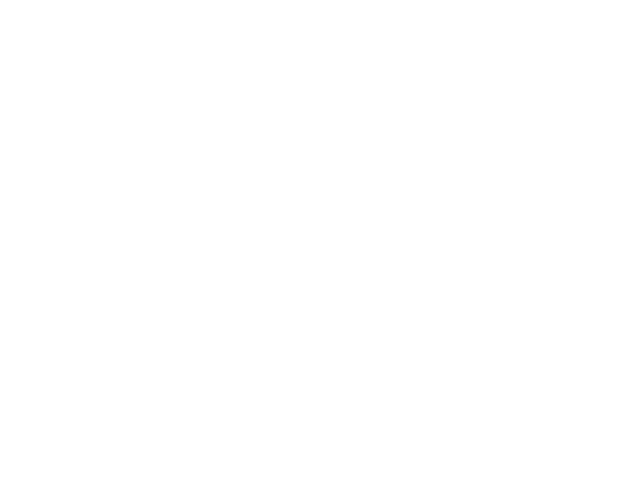

In [95]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()
plt.savefig('/Users/henryhoenig/Galvanize/capstones/capstone_two/hotbutton_opt.png', bbox_inches='tight')

In [96]:
feature_importances = pd.DataFrame((clf.feature_importances_), index=encoder.get_feature_names(df_hotbutton2.columns), columns=['importance']).sort_values('importance', ascending=False)

In [98]:
feature_importanc

,importance
V201387_1. Favor,0.121567
V201384_2. Oppose,0.103767
V201387_2. Oppose,0.082580
V201384_1. Favor,0.073845
V201386x_7. Oppose a great deal,0.072842
V202326_1. Approve,0.065933
V201424_2. Oppose,0.051098
V201424_1. Favor,0.050455
V202326_2. Disapprove,0.049921
V201386x_1. Favor a great deal,0.030409


In [106]:
feature_importances2 = feature_importances
feature_importances2 = feature_importances2['importance'].tolist()
feature_importances2 = feature_importances2[0:10]
feature_importances2

[0.12156707299645651,
 0.1037669663484187,
 0.08258044559636993,
 0.07384520016528466,
 0.07284245059710719,
 0.06593332366811441,
 0.05109809550038909,
 0.05045535386240622,
 0.04992052349951517,
 0.030408606478329638]

<IPython.core.display.Javascript object>


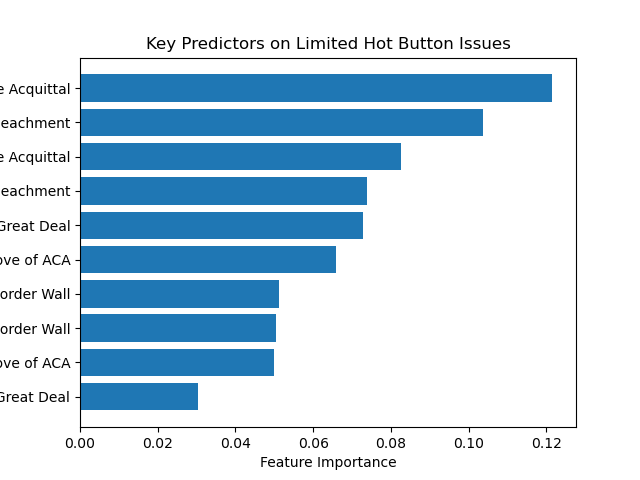

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
# np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

feature_names = ['Favor (First) Senate Acquittal', 'Oppose (First) House Impeachment', 'Oppose (First) Senate Acquittal', 'Favor (First) House Impeachment', 'Oppose (First) House Impeachment a Great Deal', 'Approve of ACA', 'Oppose Border Wall', 'Favor Border Wall', 'Disapprove of ACA', 'Favor (First) House Impeachment a Great Deal']

y_pos = np.arange(len(feature_names))
#performance = 3 + 10 * np.random.rand(len(feature_names))

ax.barh(y_pos, feature_importances2, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Key Predictors on Limited Hot Button Issues')
plt.savefig('/Users/henryhoenig/Galvanize/capstones/capstone_two/features_hotbutton_data.png', bbox_inches='tight')
plt.show()

### Plotting Permutation Feature Importance

In [103]:
X_train2 = X_train.todense()

In [104]:
perm_feature_importance = permutation_importance(clf, X_train2, y_train, n_repeats=5, random_state=0)

In [105]:
perm_sorted_idx = perm_feature_importance.importances_mean.argsort()[-1:-11:-1]
labels=encoder.get_feature_names(df_hotbutton2.columns)[perm_sorted_idx]
labels

array(['V201384_1. Favor', 'V202326_1. Approve', 'V201387_2. Oppose',
       'V202326_2. Disapprove', 'V202401_2. A little', 'V201387_1. Favor',
       'V202245x_1. Favor a great deal', 'V201428_5. Not likely at all',
       'V202549_2. Russia did not try to interfere in the 2016 presidential election',
       'V202550_1. Not at all'], dtype=object)

In [115]:
#perm_feature_importance.importances[perm_sorted_idx]
perm_sorted_idx

array([229, 137, 249, 138, 207, 248, 307, 201, 214, 217])

In [119]:
perm_feature_importance.importances_mean.max()

0.00702716172439577

In [123]:
perm_features = perm_feature_importance.importances_mean[perm_sorted_idx].tolist()

In [124]:
perm_features

[0.00702716172439577,
 0.004186394218788969,
 0.003339147769748374,
 0.0025915773735360804,
 0.002442063294293595,
 0.0019436830301520658,
 0.0015449788188388158,
 0.0014453027660105144,
 0.0013954647395963526,
 0.00119611263393975]

<IPython.core.display.Javascript object>


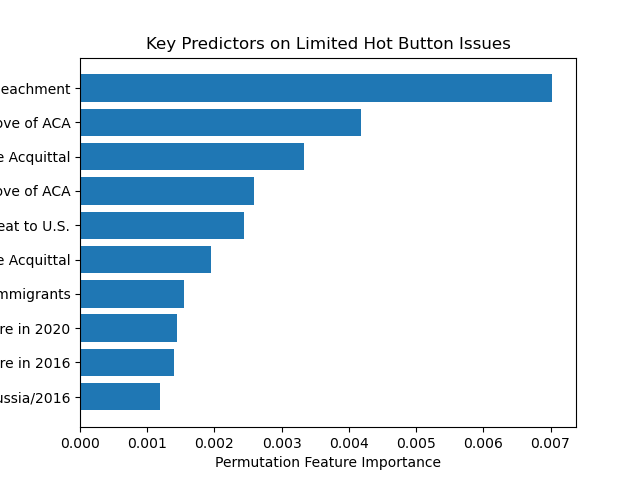

In [134]:
plt.rcdefaults()
fig, ax = plt.subplots()

perm_feature_names = ['Favor (First) House Impeachment', 'Approve of ACA', 'Oppose (First) Senate Acquittal', 'Disapprove of ACA', 'Russia Is "Little" Threat to U.S.', 'Favor (First) Senate Acquittal', 'Greatly Favor Deporting Unauthorized Immigrants', 'Russia Not Likely to Interfere in 2020', 'Russia Did Not Interfere in 2016', 'Not at All Confident in View on Russia/2016']
    
y_pos = np.arange(len(perm_feature_names))
#performance = 3 + 10 * np.random.rand(len(feature_names))

ax.barh(y_pos, perm_features, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(perm_feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Permutation Feature Importance')
ax.set_title('Key Predictors on Limited Hot Button Issues')
#plt.savefig('/Users/henryhoenig/Galvanize/capstones/capstone_two/perm_features_hotbutton_data.png', bbox_inches='tight')
plt.show()

### cross_val scores on single-topic datasets

In [67]:
dsets = [df_race, df_ACA, df_gov_health_spend, df_wall, df_impeachment, df_russia, df_immigration]
scores = []
kfold=5

for dset in dsets:
    dset2 = dset.copy()
    for col in dset.columns:
        #print(col, df[col].nunique())
        if dset[col].nunique()==1 or dset[col].nunique() > 15:
            dset2.drop(col, axis=1, inplace=True)

    dset2 = dset2.astype(str)

    encoder = OneHotEncoder()
    encoded_dset2 = encoder.fit_transform(dset2)
    encoded_dset2.todense()

    X_train, X_test, y_train, y_test = train_test_split(encoded_dset2, y, test_size = 0.3)
    clf = GradientBoostingClassifier(learning_rate=0.005, n_estimators=5000, random_state=7, max_depth=4, min_samples_leaf=1, max_features=0.1)
    clf.fit(X_train, y_train)
    cross_val_results = cross_val_score(clf, encoded_dset2, y, cv=kfold, scoring='accuracy')
    scores.append(cross_val_results.mean())
print(scores)

[0.8681308398416995, 0.8775489896246527, 0.7671394076055451, 0.8775470116290924, 0.9337166080114907, 0.8458047474936514, 0.8438830487302029]


In [132]:
print('Five-fold cross validation scores by topic of dataset:')
print("")
print(f'Ukraine impeachment (5 questions): {scores[4].round(3)}')
print(f'ACA (3):                           {scores[1].round(3)}')
print(f'Border wall (3):                   {scores[3].round(3)}')
print(f'Race (20):                         {scores[0].round(3)}')
print(f'Russia interference/threat (4):    {scores[5].round(3)}')
print(f'Immigration (21):                  {scores[6].round(3)}')
print(f'Govt health care spending (3):     {scores[2].round(3)}')

Five-fold cross validation scores by topic of dataset:

Ukraine impeachment (5 questions): 0.934
ACA (3):                           0.878
Border wall (3):                   0.878
Race (20):                         0.868
Russia interference/threat (4):    0.846
Immigration (21):                  0.844
Govt health care spending (3):     0.767


In [135]:
dset = df_impeachment
kfold=5

dset2 = dset.copy()
for col in dset.columns:
    #print(col, df[col].nunique())
    if dset[col].nunique()==1 or dset[col].nunique() > 15:
        dset2.drop(col, axis=1, inplace=True)

dset2 = dset2.astype(str)

encoder = OneHotEncoder()
encoded_dset2 = encoder.fit_transform(dset2)
encoded_dset2.todense()

X_train, X_test, y_train, y_test = train_test_split(encoded_dset2, y, test_size = 0.3)
clf = GradientBoostingClassifier(learning_rate=0.005, n_estimators=5000, random_state=7, max_depth=4, min_samples_leaf=1, max_features=0.1)
clf.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.005, max_depth=4, max_features=0.1,
                           n_estimators=5000, random_state=7)

<IPython.core.display.Javascript object>


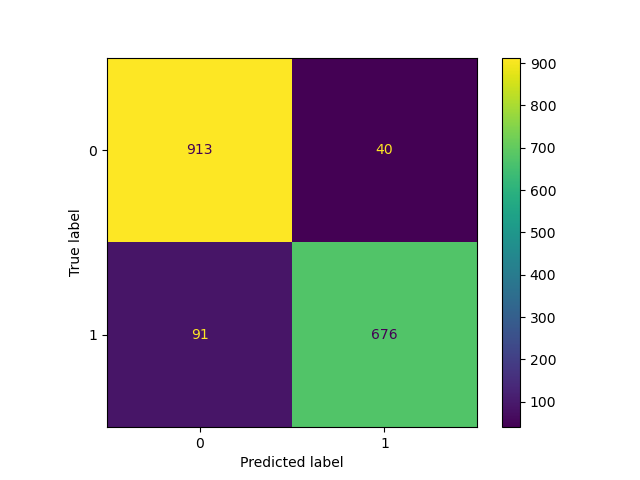

In [136]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()
#plt.savefig('/Users/henryhoenig/Galvanize/capstones/capstone_two/impeachment_confmat.png', bbox_inches='tight')

In [137]:
dset = df_wall
kfold=5

dset2 = dset.copy()
for col in dset.columns:
    #print(col, df[col].nunique())
    if dset[col].nunique()==1 or dset[col].nunique() > 15:
        dset2.drop(col, axis=1, inplace=True)

dset2 = dset2.astype(str)

encoder = OneHotEncoder()
encoded_dset2 = encoder.fit_transform(dset2)
encoded_dset2.todense()

X_train, X_test, y_train, y_test = train_test_split(encoded_dset2, y, test_size = 0.3)
clf = GradientBoostingClassifier(learning_rate=0.005, n_estimators=5000, random_state=7, max_depth=4, min_samples_leaf=1, max_features=0.1)
clf.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.005, max_depth=4, max_features=0.1,
                           n_estimators=5000, random_state=7)

<IPython.core.display.Javascript object>


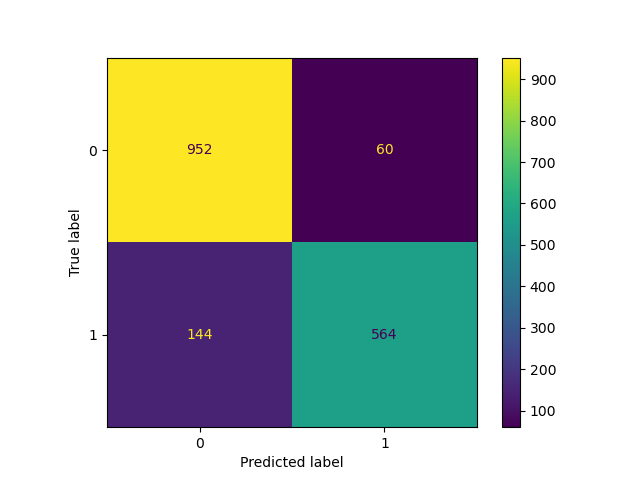

In [138]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()
#bplt.savefig('/Users/henryhoenig/Galvanize/capstones/capstone_two/wall_confmat.png', bbox_inches='tight')

In [139]:
dset = df_ACA
kfold=5

dset2 = dset.copy()
for col in dset.columns:
    #print(col, df[col].nunique())
    if dset[col].nunique()==1 or dset[col].nunique() > 15:
        dset2.drop(col, axis=1, inplace=True)

dset2 = dset2.astype(str)

encoder = OneHotEncoder()
encoded_dset2 = encoder.fit_transform(dset2)
encoded_dset2.todense()

X_train, X_test, y_train, y_test = train_test_split(encoded_dset2, y, test_size = 0.3)
clf = GradientBoostingClassifier(learning_rate=0.005, n_estimators=5000, random_state=7, max_depth=4, min_samples_leaf=1, max_features=0.1)
clf.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.005, max_depth=4, max_features=0.1,
                           n_estimators=5000, random_state=7)

<IPython.core.display.Javascript object>


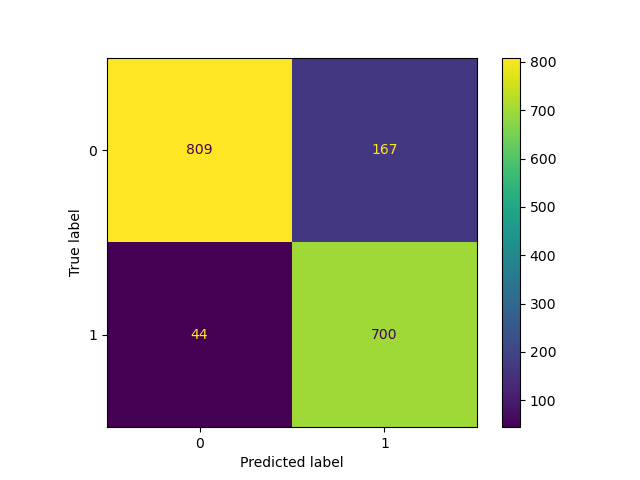

In [141]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()
#plt.savefig('/Users/henryhoenig/Galvanize/capstones/capstone_two/ACA_confmat.png', bbox_inches='tight')

In [ ]:
# counter = 0
# for i in range(len(df)):
#     if df['V202326'].iloc[i] == '3. Neither approve nor disapprove' and (df['V202073'].iloc[i] == '1. Joe Biden' or df['V201029'].iloc[i] == '1. Joe Biden'):
#         counter +=1 
# print(counter)

In [ ]:
# 178 people approved of ACA but voted for Trump
# 529 were Neither approve nor disapprove and voted for Trump
# 118 disapproved and voted for Biden
# 438 neither approved nor disapproved and voted Biden